In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

In [2]:
no_epochs = 100
lr_SGD = 0.01
lr_Adam = 0.01
pat = 5
fact = 0.1
th = 0.0001
ep = 1e-20
colors = ['c', 'y', 'r', 'b', 'k', 'm', 'g', 'w']*10

In [3]:
epochs_for_89_th_train_eff = []
epochs_for_89_th_val_eff = []
#epochs_for_90_th_train_eff = []
#epochs_for_90_th_val_eff = []
test_eff = []
th_eff1 = 89
#th_eff2 = 90
methods = np.array(['SGD with CE', 'Adam with CE', 'SGD with NLL', 'Adam with NLL'])
xpos = np.arange(len(methods))

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.manual_seed(0)
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5, 5), stride = (1, 1), padding = (0, 0))
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5, 5), stride = (1, 1), padding = (0, 0))
        self.linear1 = nn.Linear(256, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x
    
net = LeNet()
net.to(device)

LeNet(
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=256, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
optimizer1 = optim.SGD(net.parameters(), lr_SGD, 0.95)
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer1, 'min', factor = fact, patience = pat, threshold = th, eps = ep, verbose = 'True')
optimizer2 = optim.Adam(net.parameters(), lr_Adam, [0.9, 0.999])
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', factor = fact, patience = pat, threshold = th, eps = ep, verbose = 'True')
loss1 = nn.CrossEntropyLoss()

In [7]:
train_set = datasets.FashionMNIST("./data", download = False, transform = transforms.Compose([transforms.ToTensor()]))
test_set = datasets.FashionMNIST("./data", download = False, train = False, transform = transforms.Compose([transforms.ToTensor()]))
train , val = random_split(train_set, [55000, 5000])
train_loader = DataLoader(train, batch_size = 100)
val_loader = DataLoader(val, batch_size = 100)
test_loader = DataLoader(test_set, batch_size = 100)

In [8]:
th_train_eff_89_alarm = True
th_val_eff_89_alarm = True
#th_train_eff_90_alarm = True
#th_val_eff_90_alarm = True
lr_chng_ep = [0]
lr_list = [f'{lr_SGD : .1e}']
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epochs in range(no_epochs):
    losses = []
    correct = 0
    total = 0
    for batch in train_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        logit = net.forward(x)
        J = loss1(logit, y)
        net.zero_grad()
        J.backward()
        optimizer1.step()
        losses.append(J.item())
        _, predicted = torch.max(logit.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum()
    train_losses.append((torch.tensor(losses).mean()).item())
    train_acc.append(100 * correct / total)
    if (100 * correct / total) >= th_eff1 and th_train_eff_89_alarm :
        epochs_for_89_th_train_eff.append(epochs)
        th_train_eff_89_alarm = False
    '''if (100 * correct / total) >= th_eff2 and th_train_eff_90_alarm :
        epochs_for_90_th_train_eff.append(epochs)
        th_train_eff_90_alarm = False'''
    print(f'Epoch : {epochs + 1}, train loss : {torch.tensor(losses).mean() : .2f}, training accuracy : {100 * correct / total : .2f}')
    losses = []
    correct = 0
    total = 0
    for batch in val_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logit = net.forward(x)
        J = loss1(logit, y)
        losses.append(J.item())
        _, predicted = torch.max(logit.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum()
    val_losses.append((torch.tensor(losses).mean()).item())
    lr_init = optimizer1.param_groups[0]['lr']
    scheduler1.step((torch.tensor(losses).mean()).item())
    lr_final = optimizer1.param_groups[0]['lr']
    if lr_init != lr_final and epochs != no_epochs-1 :
        lr_chng_ep.append(epochs)
        lr_list.append(f'{lr_final : .1e}')
    val_acc.append(100 * correct / total)
    if (100 * correct / total) >= th_eff1 and th_val_eff_89_alarm :
        epochs_for_89_th_val_eff.append(epochs)
        th_val_eff_89_alarm = False
    '''if (100 * correct / total) >= th_eff2 and th_val_eff_90_alarm :
        epochs_for_90_th_val_eff.append(epochs)
        th_val_eff_90_alarm = False'''
    print(f'Epoch : {epochs + 1}, validation loss : {torch.tensor(val_losses).mean() : .2f}, validation accuracy : {100 * correct / total : .2f}')
lr_chng_ep.append(no_epochs-1)

Epoch : 1, train loss :  1.06, training accuracy :  60.26
Epoch : 1, validation loss :  0.58, validation accuracy :  78.80
Epoch : 2, train loss :  0.48, training accuracy :  82.19
Epoch : 2, validation loss :  0.51, validation accuracy :  83.66
Epoch : 3, train loss :  0.39, training accuracy :  85.57
Epoch : 3, validation loss :  0.47, validation accuracy :  86.06
Epoch : 4, train loss :  0.35, training accuracy :  87.09
Epoch : 4, validation loss :  0.44, validation accuracy :  87.24
Epoch : 5, train loss :  0.32, training accuracy :  88.03
Epoch : 5, validation loss :  0.42, validation accuracy :  88.22
Epoch : 6, train loss :  0.30, training accuracy :  88.73
Epoch : 6, validation loss :  0.40, validation accuracy :  88.42
Epoch : 7, train loss :  0.29, training accuracy :  89.15
Epoch : 7, validation loss :  0.39, validation accuracy :  88.98
Epoch : 8, train loss :  0.28, training accuracy :  89.69
Epoch : 8, validation loss :  0.38, validation accuracy :  89.18
Epoch : 9, train

Epoch    63: reducing learning rate of group 0 to 1.0000e-10.
Epoch : 63, validation loss :  0.31, validation accuracy :  91.00
Epoch : 64, train loss :  0.13, training accuracy :  95.19
Epoch : 64, validation loss :  0.31, validation accuracy :  91.00
Epoch : 65, train loss :  0.13, training accuracy :  95.19
Epoch : 65, validation loss :  0.31, validation accuracy :  91.00
Epoch : 66, train loss :  0.13, training accuracy :  95.19
Epoch : 66, validation loss :  0.31, validation accuracy :  91.00
Epoch : 67, train loss :  0.13, training accuracy :  95.19
Epoch : 67, validation loss :  0.31, validation accuracy :  91.00
Epoch : 68, train loss :  0.13, training accuracy :  95.19
Epoch : 68, validation loss :  0.31, validation accuracy :  91.00
Epoch : 69, train loss :  0.13, training accuracy :  95.19
Epoch    69: reducing learning rate of group 0 to 1.0000e-11.
Epoch : 69, validation loss :  0.31, validation accuracy :  91.00
Epoch : 70, train loss :  0.13, training accuracy :  95.19
E

In [9]:
net.eval()
correct = 0
total = 0
for batch in test_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)
    logit = net.forward(x)
    _, predicted = torch.max(logit.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))
test_eff.append((100 * correct / total).item())

Test Accuracy of the model on the 10000 test images: 90.2500 %


Plots using SGD optimizer and Cross Entropy loss


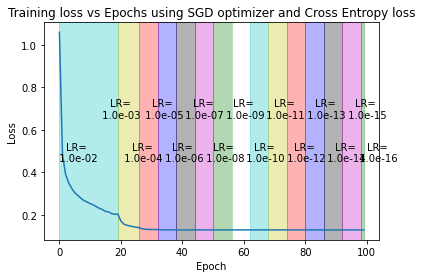

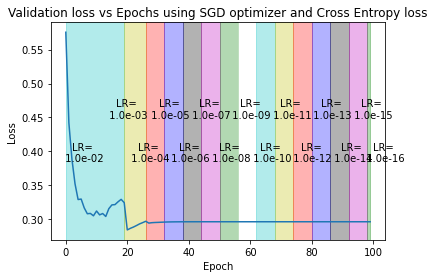

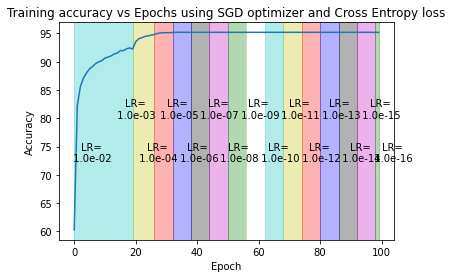

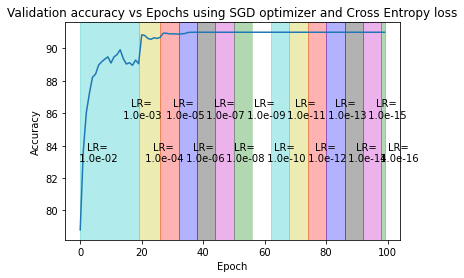

In [10]:
print('Plots using SGD optimizer and Cross Entropy loss')
#plt.xkcd()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
    '''plt.text(lr_chng_ep[i], 0.05, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Training loss vs Epochs using SGD optimizer and Cross Entropy loss')
plt.savefig('Training loss vs Epochs using SGD & CSE.jpg', bbox_inches = 'tight')
plt.show()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(val_losses)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
'''for i in range(1, len(lr_chng_ep)-1):
    plt.text(lr_chng_ep[i], 0.2505, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Validation loss vs Epochs using SGD optimizer and Cross Entropy loss')
plt.savefig('Validation loss vs Epochs using SGD & CSE.jpg', bbox_inches = 'tight')
plt.show()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_acc)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
'''for i in range(1, len(lr_chng_ep)-1):
    plt.text(lr_chng_ep[i], 47.5, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Training accuracy vs Epochs using SGD optimizer and Cross Entropy loss')
plt.savefig('Training accuracy vs Epochs using SGD & CSE.jpg', bbox_inches = 'tight')
plt.show()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(val_acc)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
    '''plt.text(lr_chng_ep[i], 75, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Validation accuracy vs Epochs using SGD optimizer and Cross Entropy loss')
plt.savefig('Validation accuracy vs Epochs using SGD & CSE.jpg', bbox_inches = 'tight')
plt.show()

In [11]:
for module in net.children():
    if hasattr(module, 'reset_parameters'):
        module.reset_parameters()

In [12]:
th_train_eff_89_alarm = True
th_val_eff_89_alarm = True
#th_train_eff_90_alarm = True
#th_val_eff_90_alarm = True
lr_chng_ep = [0]
lr_list = [f'{lr_Adam : .1e}']
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epochs in range(no_epochs):
    losses = []
    correct = 0
    total = 0
    for batch in train_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        logit = net.forward(x)
        J = loss1(logit, y)
        net.zero_grad()
        J.backward()
        optimizer2.step()
        losses.append(J.item())
        _, predicted = torch.max(logit.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum()
    train_losses.append((torch.tensor(losses).mean()).item())
    train_acc.append(100 * correct / total)
    if (100 * correct / total) >= th_eff1 and th_train_eff_89_alarm :
        epochs_for_89_th_train_eff.append(epochs)
        th_train_eff_89_alarm = False
    '''if (100 * correct / total) >= th_eff2 and th_train_eff_90_alarm :
        epochs_for_90_th_train_eff.append(epochs)
        th_train_eff_90_alarm = False'''
    print(f'Epoch : {epochs + 1}, train loss : {torch.tensor(losses).mean() : .2f}, training accuracy : {100 * correct / total : .2f}')
    losses = []
    correct = 0
    total = 0
    for batch in val_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logit = net.forward(x)
        J = loss1(logit, y)
        losses.append(J.item())
        _, predicted = torch.max(logit.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum()
    val_losses.append((torch.tensor(losses).mean()).item())
    lr_init = optimizer2.param_groups[0]['lr']
    scheduler2.step((torch.tensor(losses).mean()).item())
    lr_final = optimizer2.param_groups[0]['lr']
    if lr_init != lr_final and epochs != no_epochs-1 :
        lr_chng_ep.append(epochs)
        lr_list.append(f'{lr_final : .1e}')
    val_acc.append(100 * correct / total)
    if (100 * correct / total) >= th_eff1 and th_val_eff_89_alarm :
        epochs_for_89_th_val_eff.append(epochs)
        th_val_eff_89_alarm = False
    '''if (100 * correct / total) >= th_eff2 and th_val_eff_90_alarm :
        epochs_for_90_th_val_eff.append(epochs)
        th_val_eff_90_alarm = False'''
    print(f'Epoch : {epochs + 1}, validation loss : {torch.tensor(val_losses).mean() : .2f}, validation accuracy : {100 * correct / total : .2f}')
lr_chng_ep.append(no_epochs-1)

Epoch : 1, train loss :  0.60, training accuracy :  77.47
Epoch : 1, validation loss :  0.43, validation accuracy :  84.42
Epoch : 2, train loss :  0.41, training accuracy :  85.11
Epoch : 2, validation loss :  0.41, validation accuracy :  86.40
Epoch : 3, train loss :  0.37, training accuracy :  86.24
Epoch : 3, validation loss :  0.40, validation accuracy :  85.60
Epoch : 4, train loss :  0.36, training accuracy :  86.83
Epoch : 4, validation loss :  0.39, validation accuracy :  87.34
Epoch : 5, train loss :  0.34, training accuracy :  87.39
Epoch : 5, validation loss :  0.38, validation accuracy :  86.66
Epoch : 6, train loss :  0.34, training accuracy :  87.62
Epoch : 6, validation loss :  0.38, validation accuracy :  87.94
Epoch : 7, train loss :  0.33, training accuracy :  87.96
Epoch : 7, validation loss :  0.37, validation accuracy :  87.46
Epoch : 8, train loss :  0.32, training accuracy :  87.98
Epoch : 8, validation loss :  0.37, validation accuracy :  87.58
Epoch : 9, train

Epoch : 63, train loss :  0.18, training accuracy :  93.06
Epoch : 63, validation loss :  0.33, validation accuracy :  90.04
Epoch : 64, train loss :  0.18, training accuracy :  93.06
Epoch : 64, validation loss :  0.33, validation accuracy :  90.04
Epoch : 65, train loss :  0.18, training accuracy :  93.06
Epoch : 65, validation loss :  0.33, validation accuracy :  90.04
Epoch : 66, train loss :  0.18, training accuracy :  93.06
Epoch : 66, validation loss :  0.33, validation accuracy :  90.04
Epoch : 67, train loss :  0.18, training accuracy :  93.06
Epoch : 67, validation loss :  0.33, validation accuracy :  90.04
Epoch : 68, train loss :  0.18, training accuracy :  93.06
Epoch    68: reducing learning rate of group 0 to 1.0000e-12.
Epoch : 68, validation loss :  0.33, validation accuracy :  90.04
Epoch : 69, train loss :  0.18, training accuracy :  93.06
Epoch : 69, validation loss :  0.33, validation accuracy :  90.04
Epoch : 70, train loss :  0.18, training accuracy :  93.06
Epoc

In [13]:
net.eval()
correct = 0
total = 0
for batch in test_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)
    logit = net.forward(x)
    _, predicted = torch.max(logit.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))
test_eff.append((100 * correct / total).item())

Test Accuracy of the model on the 10000 test images: 88.9200 %


Plots using Adam optimizer and Cross Entropy loss


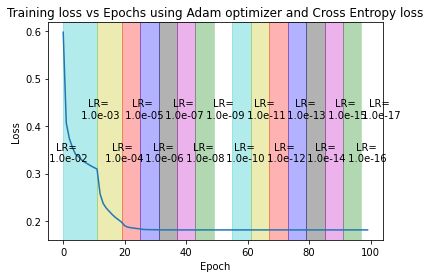

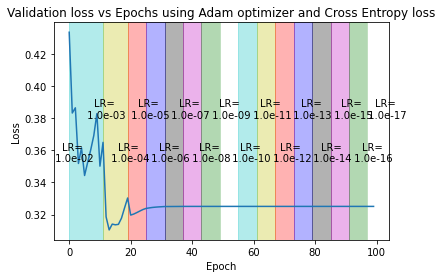

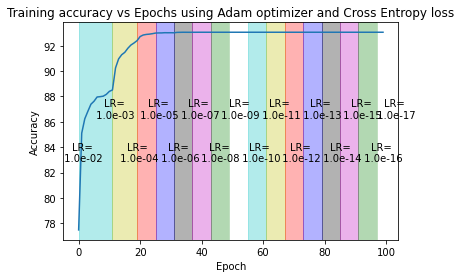

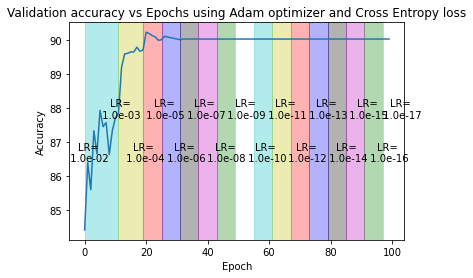

In [14]:
print('Plots using Adam optimizer and Cross Entropy loss')
#plt.xkcd()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
'''for i in range(1, len(lr_chng_ep)-1):
    plt.text(lr_chng_ep[i], 0.1, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Training loss vs Epochs using Adam optimizer and Cross Entropy loss')
plt.savefig('Training loss vs Epochs using Adam & CSE.jpg', bbox_inches = 'tight')
plt.show()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(val_losses)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
'''for i in range(1, len(lr_chng_ep)-1):
    plt.text(lr_chng_ep[i], 0.29, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Validation loss vs Epochs using Adam optimizer and Cross Entropy loss')
plt.savefig('Validation loss vs Epochs using Adam & CSE.jpg', bbox_inches = 'tight')
plt.show()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_acc)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
'''for i in range(1, len(lr_chng_ep)-1):
    plt.text(lr_chng_ep[i], 73, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Training accuracy vs Epochs using Adam optimizer and Cross Entropy loss')
plt.savefig('Training accuracy vs Epochs using Adam & CSE.jpg', bbox_inches = 'tight')
plt.show()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(val_acc)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
'''for i in range(1, len(lr_chng_ep)-1):
    plt.text(lr_chng_ep[i], 83, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Validation accuracy vs Epochs using Adam optimizer and Cross Entropy loss')
plt.savefig('Validation accuracy vs Epochs using Adam & CSE.jpg', bbox_inches = 'tight')
plt.show()

In [15]:
torch.manual_seed(0)
class LeNet2(nn.Module):
    def __init__(self):
        super(LeNet2, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = (2, 2), stride = (2, 2))
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5, 5), stride = (1, 1), padding = (0, 0))
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5, 5), stride = (1, 1), padding = (0, 0))
        self.linear1 = nn.Linear(256, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)
        self.logsoftmax = nn.LogSoftmax(1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.logsoftmax(x)
        return x
    
net2 = LeNet2()
net2.to(device)

LeNet2(
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=256, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [16]:
optimizer1 = optim.SGD(net2.parameters(), lr_SGD, 0.95)
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer1, 'min', factor = fact, patience = pat, threshold = th, eps = ep, verbose = 'True')
optimizer2 = optim.Adam(net2.parameters(), lr_Adam, [0.9, 0.999])
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, 'min', factor = fact, patience = pat, threshold = th, eps = ep, verbose = 'True')
loss2 = nn.NLLLoss()

In [17]:
th_train_eff_89_alarm = True
th_val_eff_89_alarm = True
#th_train_eff_90_alarm = True
#th_val_eff_90_alarm = True
lr_chng_ep = [0]
lr_list = [f'{lr_SGD : .1e}']
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epochs in range(no_epochs):
    losses = []
    correct = 0
    total = 0
    for batch in train_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        logit = net2.forward(x)
        J = loss2(logit, y)
        net2.zero_grad()
        J.backward()
        optimizer1.step()
        losses.append(J.item())
        _, predicted = torch.max(logit.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum()
    train_losses.append((torch.tensor(losses).mean()).item())
    train_acc.append(100 * correct / total)
    if (100 * correct / total) >= th_eff1 and th_train_eff_89_alarm :
        epochs_for_89_th_train_eff.append(epochs)
        th_train_eff_89_alarm = False
    '''if (100 * correct / total) >= th_eff2 and th_train_eff_90_alarm :
        epochs_for_90_th_train_eff.append(epochs)
        th_train_eff_90_alarm = False'''
    print(f'Epoch : {epochs + 1}, train loss : {torch.tensor(losses).mean() : .2f}, training accuracy : {100 * correct / total : .2f}')
    losses = []
    correct = 0
    total = 0
    for batch in val_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logit = net2.forward(x)
        J = loss2(logit, y)
        losses.append(J.item())
        _, predicted = torch.max(logit.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum()
    val_losses.append((torch.tensor(losses).mean()).item())
    lr_init = optimizer1.param_groups[0]['lr']
    scheduler1.step((torch.tensor(losses).mean()).item())
    lr_final = optimizer1.param_groups[0]['lr']
    if lr_init != lr_final and epochs != no_epochs-1 :
        lr_chng_ep.append(epochs)
        lr_list.append(f'{lr_final : .1e}')
    val_acc.append(100 * correct / total)
    if (100 * correct / total) >= th_eff1 and th_val_eff_89_alarm :
        epochs_for_89_th_val_eff.append(epochs)
        th_val_eff_89_alarm = False
    '''if (100 * correct / total) >= th_eff2 and th_val_eff_90_alarm :
        epochs_for_90_th_val_eff.append(epochs)
        th_val_eff_90_alarm = False'''
    print(f'Epoch : {epochs + 1}, validation loss : {torch.tensor(val_losses).mean() : .2f}, validation accuracy : {100 * correct / total : .2f}')
lr_chng_ep.append(no_epochs-1)

Epoch : 1, train loss :  1.13, training accuracy :  57.18
Epoch : 1, validation loss :  0.66, validation accuracy :  75.02
Epoch : 2, train loss :  0.54, training accuracy :  79.47
Epoch : 2, validation loss :  0.57, validation accuracy :  81.62
Epoch : 3, train loss :  0.45, training accuracy :  83.31
Epoch : 3, validation loss :  0.53, validation accuracy :  83.44
Epoch : 4, train loss :  0.40, training accuracy :  85.14
Epoch : 4, validation loss :  0.50, validation accuracy :  84.96
Epoch : 5, train loss :  0.37, training accuracy :  86.31
Epoch : 5, validation loss :  0.47, validation accuracy :  86.72
Epoch : 6, train loss :  0.35, training accuracy :  87.15
Epoch : 6, validation loss :  0.45, validation accuracy :  86.76
Epoch : 7, train loss :  0.33, training accuracy :  87.85
Epoch : 7, validation loss :  0.44, validation accuracy :  87.82
Epoch : 8, train loss :  0.32, training accuracy :  88.41
Epoch : 8, validation loss :  0.42, validation accuracy :  88.16
Epoch : 9, train

Epoch : 63, validation loss :  0.30, validation accuracy :  90.96
Epoch : 64, train loss :  0.16, training accuracy :  94.18
Epoch : 64, validation loss :  0.30, validation accuracy :  90.96
Epoch : 65, train loss :  0.16, training accuracy :  94.18
Epoch : 65, validation loss :  0.30, validation accuracy :  90.96
Epoch : 66, train loss :  0.16, training accuracy :  94.18
Epoch : 66, validation loss :  0.30, validation accuracy :  90.96
Epoch : 67, train loss :  0.16, training accuracy :  94.18
Epoch    67: reducing learning rate of group 0 to 1.0000e-10.
Epoch : 67, validation loss :  0.30, validation accuracy :  90.96
Epoch : 68, train loss :  0.16, training accuracy :  94.18
Epoch : 68, validation loss :  0.30, validation accuracy :  90.96
Epoch : 69, train loss :  0.16, training accuracy :  94.18
Epoch : 69, validation loss :  0.30, validation accuracy :  90.96
Epoch : 70, train loss :  0.16, training accuracy :  94.18
Epoch : 70, validation loss :  0.30, validation accuracy :  90.

In [18]:
net2.eval()
correct = 0
total = 0
for batch in test_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)
    logit = net2.forward(x)
    _, predicted = torch.max(logit.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))
test_eff.append((100 * correct / total).item())

Test Accuracy of the model on the 10000 test images: 90.5700 %


Plots using SGD optimizer and Negative Log Likelihood loss


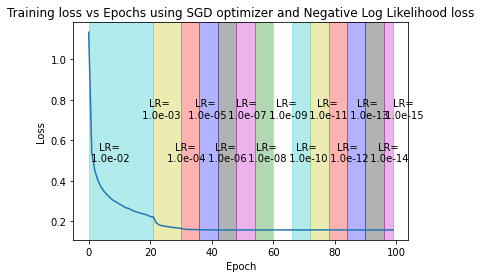

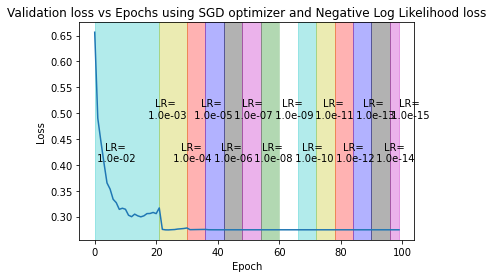

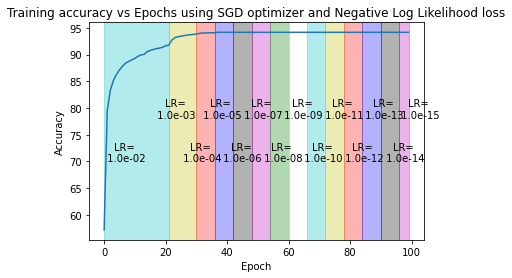

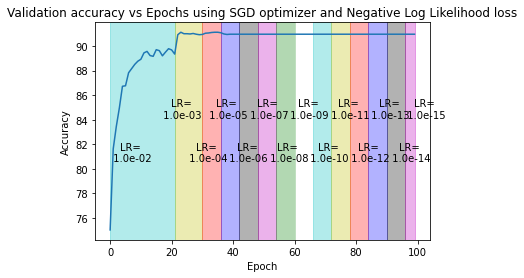

In [19]:
print('Plots using SGD optimizer and Negative Log Likelihood loss')
#plt.xkcd()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses)
#print(len(lr_chng_ep))
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
'''for i in range(1, len(lr_chng_ep)-1):
    plt.text(lr_chng_ep[i], 0.05, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Training loss vs Epochs using SGD optimizer and Negative Log Likelihood loss')
plt.savefig('Training loss vs Epochs using SGD & NLL.jpg', bbox_inches = 'tight')
plt.show()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(val_losses)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
'''for i in range(1, len(lr_chng_ep)-1):
    plt.text(lr_chng_ep[i], 0.2, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Validation loss vs Epochs using SGD optimizer and Negative Log Likelihood loss')
plt.savefig('Validation loss vs Epochs using SGD & NLL.jpg', bbox_inches = 'tight')
plt.show()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_acc)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
'''for i in range(1, len(lr_chng_ep)-1):
    plt.text(lr_chng_ep[i], 40, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Training accuracy vs Epochs using SGD optimizer and Negative Log Likelihood loss')
plt.savefig('Training accuracy vs Epochs using SGD & NLL.jpg', bbox_inches = 'tight')
plt.show()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(val_acc)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
'''for i in range(1, len(lr_chng_ep)-1):
    plt.text(lr_chng_ep[i], 71.25, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Validation accuracy vs Epochs using SGD optimizer and Negative Log Likelihood loss')
plt.savefig('Validation accuracy vs Epochs using SGD & NLL.jpg', bbox_inches = 'tight')
plt.show()

In [20]:
for module in net2.children():
    if hasattr(module, 'reset_parameters'):
        module.reset_parameters()

In [21]:
th_train_eff_89_alarm = True
th_val_eff_89_alarm = True
#th_train_eff_90_alarm = True
#th_val_eff_90_alarm = True
lr_chng_ep = [0]
lr_list = [f'{lr_Adam : .1e}']
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epochs in range(no_epochs):
    losses = []
    correct = 0
    total = 0
    for batch in train_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        logit = net2.forward(x)
        J = loss2(logit, y)
        net2.zero_grad()
        J.backward()
        optimizer2.step()
        losses.append(J.item())
        _, predicted = torch.max(logit.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum()
    train_losses.append((torch.tensor(losses).mean()).item())
    train_acc.append(100 * correct / total)
    if (100 * correct / total) >= th_eff1 and th_train_eff_89_alarm :
        epochs_for_89_th_train_eff.append(epochs)
        th_train_eff_89_alarm = False
    '''if (100 * correct / total) >= th_eff2 and th_train_eff_90_alarm :
        epochs_for_90_th_train_eff.append(epochs)
        th_train_eff_90_alarm = False'''
    print(f'Epoch : {epochs + 1}, train loss : {torch.tensor(losses).mean() : .2f}, training accuracy : {100 * correct / total : .2f}')
    losses = []
    correct = 0
    total = 0
    for batch in val_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logit = net2.forward(x)
        J = loss2(logit, y)
        losses.append(J.item())
        _, predicted = torch.max(logit.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum()
    val_losses.append((torch.tensor(losses).mean()).item())
    lr_init = optimizer2.param_groups[0]['lr']
    scheduler2.step((torch.tensor(losses).mean()).item())
    lr_final = optimizer2.param_groups[0]['lr']
    if lr_init != lr_final and epochs != no_epochs-1 :
        lr_chng_ep.append(epochs)
        lr_list.append(f'{lr_final : .1e}')
    val_acc.append(100 * correct / total)
    if (100 * correct / total) >= th_eff1 and th_val_eff_89_alarm :
        epochs_for_89_th_val_eff.append(epochs)
        th_val_eff_89_alarm = False
    '''if (100 * correct / total) >= th_eff2 and th_val_eff_90_alarm :
        epochs_for_90_th_val_eff.append(epochs)
        th_val_eff_90_alarm = False'''
    print(f'Epoch : {epochs + 1}, validation loss : {torch.tensor(val_losses).mean() : .2f}, validation accuracy : {100 * correct / total : .2f}')
lr_chng_ep.append(no_epochs-1)

Epoch : 1, train loss :  0.65, training accuracy :  75.24
Epoch : 1, validation loss :  0.47, validation accuracy :  82.60
Epoch : 2, train loss :  0.42, training accuracy :  84.22
Epoch : 2, validation loss :  0.43, validation accuracy :  85.58
Epoch : 3, train loss :  0.38, training accuracy :  85.77
Epoch : 3, validation loss :  0.40, validation accuracy :  87.06
Epoch : 4, train loss :  0.36, training accuracy :  86.67
Epoch : 4, validation loss :  0.39, validation accuracy :  86.64
Epoch : 5, train loss :  0.34, training accuracy :  87.48
Epoch : 5, validation loss :  0.39, validation accuracy :  86.84
Epoch : 6, train loss :  0.32, training accuracy :  88.02
Epoch : 6, validation loss :  0.38, validation accuracy :  86.78
Epoch : 7, train loss :  0.31, training accuracy :  88.44
Epoch : 7, validation loss :  0.38, validation accuracy :  87.66
Epoch : 8, train loss :  0.31, training accuracy :  88.56
Epoch : 8, validation loss :  0.37, validation accuracy :  86.66
Epoch : 9, train

Epoch : 63, train loss :  0.16, training accuracy :  93.69
Epoch : 63, validation loss :  0.33, validation accuracy :  90.10
Epoch : 64, train loss :  0.16, training accuracy :  93.69
Epoch    64: reducing learning rate of group 0 to 1.0000e-11.
Epoch : 64, validation loss :  0.33, validation accuracy :  90.10
Epoch : 65, train loss :  0.16, training accuracy :  93.69
Epoch : 65, validation loss :  0.33, validation accuracy :  90.10
Epoch : 66, train loss :  0.16, training accuracy :  93.69
Epoch : 66, validation loss :  0.33, validation accuracy :  90.10
Epoch : 67, train loss :  0.16, training accuracy :  93.69
Epoch : 67, validation loss :  0.33, validation accuracy :  90.10
Epoch : 68, train loss :  0.16, training accuracy :  93.69
Epoch : 68, validation loss :  0.33, validation accuracy :  90.10
Epoch : 69, train loss :  0.16, training accuracy :  93.69
Epoch : 69, validation loss :  0.33, validation accuracy :  90.10
Epoch : 70, train loss :  0.16, training accuracy :  93.69
Epoc

In [22]:
net2.eval()
correct = 0
total = 0
for batch in test_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)
    logit = net2.forward(x)
    _, predicted = torch.max(logit.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))
test_eff.append((100 * correct / total).item())

Test Accuracy of the model on the 10000 test images: 89.1500 %


Plots using Adam optimizer and Negative Log Likelihood loss


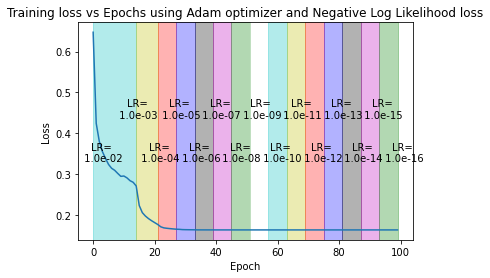

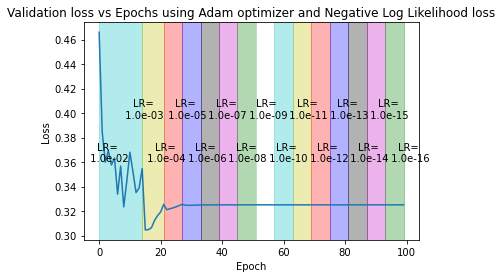

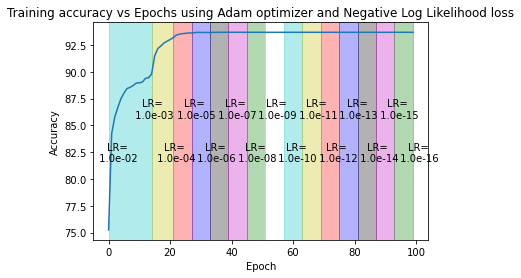

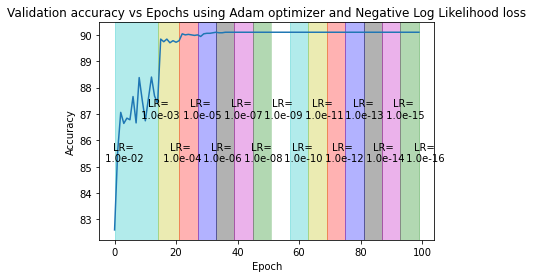

In [23]:
print('Plots using Adam optimizer and Negative Log Likelihood loss')
#plt.xkcd()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
    '''for i in range(1, len(lr_chng_ep)-1):
    plt.text(lr_chng_ep[i], 0.1, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Training loss vs Epochs using Adam optimizer and Negative Log Likelihood loss')
plt.savefig('Training loss vs Epochs using Adam & NLL.jpg', bbox_inches = 'tight')
plt.show()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(val_losses)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
'''for i in range(1, len(lr_chng_ep)-1):
    plt.text(lr_chng_ep[i], 0.275, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Validation loss vs Epochs using Adam optimizer and Negative Log Likelihood loss')
plt.savefig('Validation loss vs Epochs using Adam & NLL.jpg', bbox_inches = 'tight')
plt.show()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_acc)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
'''for i in range(1, len(lr_chng_ep)-1):
    plt.text(lr_chng_ep[i], 71.25, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Training accuracy vs Epochs using Adam optimizer and Negative Log Likelihood loss')
plt.savefig('Training accuracy vs Epochs using Adam & NLL.jpg', bbox_inches = 'tight')
plt.show()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(val_acc)
for i in range(len(lr_chng_ep)-1):
    ax = plt.gca()
    plt.axvspan(lr_chng_ep[i], lr_chng_ep[i+1], color = colors[i], alpha = 0.3)
    plt.text(((lr_chng_ep[i]+lr_chng_ep[i+1])/2)/(no_epochs-1), 0.5-0.1*pow(-1, i), f'LR=\n{lr_list[i]}', ha = 'center', va = 'center', transform = ax.transAxes)
'''for i in range(1, len(lr_chng_ep)-1):
    plt.text(lr_chng_ep[i], 80, f'{lr_chng_ep[i]}', ha = 'center', va = 'center')'''
plt.title('Validation accuracy vs Epochs using Adam optimizer and Negative Log Likelihood loss')
plt.savefig('Validation accuracy vs Epochs using Adam & NLL.jpg', bbox_inches = 'tight')
plt.show()

In [24]:
print(epochs_for_89_th_train_eff)
print(epochs_for_89_th_val_eff)
#print(epochs_for_90_th_train_eff)
#print(epochs_for_90_th_val_eff)
print(test_eff)

[6, 12, 9, 11]
[7, 12, 11, 15]
[90.25, 88.91999816894531, 90.56999969482422, 89.1500015258789]


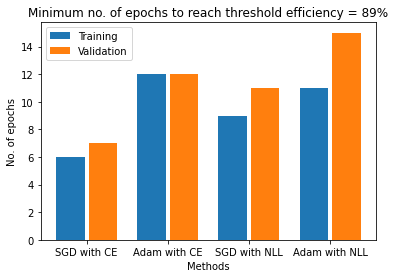

In [25]:
plt.xticks(xpos, methods)
plt.yticks(np.arange(0, 25, 2))
plt.xlabel('Methods')
plt.ylabel('No. of epochs')
plt.title('Minimum no. of epochs to reach threshold efficiency = 89%')
plt.bar(xpos-0.2, epochs_for_89_th_train_eff, width = 0.35, label = 'Training')
plt.bar(xpos+0.2, epochs_for_89_th_val_eff, width = 0.35, label = 'Validation')
plt.legend()
plt.savefig('No.of epochs for 89% eff.jpg', bbox_inches = 'tight')

In [26]:
'''plt.xticks(xpos, methods)
plt.xlabel('Methods')
plt.ylabel('No. of epochs')
plt.title('Minimum no. of epochs to reach threshold efficiency = 90%')
plt.bar(xpos-0.2, epochs_for_90_th_train_eff, width = 0.35, label = 'Training')
plt.bar(xpos+0.2, epochs_for_90_th_val_eff, width = 0.35, label = 'Validation')
plt.legend()
plt.savefig('No.of epochs for 90% eff.jpg', bbox_inches = 'tight')'''

"plt.xticks(xpos, methods)\nplt.xlabel('Methods')\nplt.ylabel('No. of epochs')\nplt.title('Minimum no. of epochs to reach threshold efficiency = 90%')\nplt.bar(xpos-0.2, epochs_for_90_th_train_eff, width = 0.35, label = 'Training')\nplt.bar(xpos+0.2, epochs_for_90_th_val_eff, width = 0.35, label = 'Validation')\nplt.legend()\nplt.savefig('No.of epochs for 90% eff.jpg', bbox_inches = 'tight')"

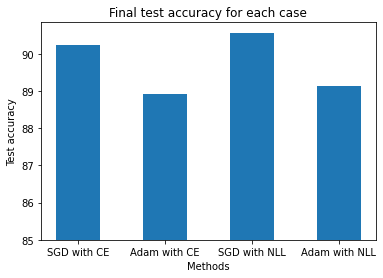

In [27]:
plt.xticks(xpos, methods)
plt.yticks(np.arange(0, 10, 1), np.arange(85, 95, 1))
plt.xlabel('Methods')
plt.ylabel('Test accuracy')
test_effi = [x-85 for x in test_eff]
plt.title('Final test accuracy for each case')
plt.bar(xpos, test_effi, width = 0.5)
plt.savefig('Test eff.jpg', bbox_inches = 'tight')